# DeepFakes Task 1 - Model 1

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import dlib
import seaborn as sns

from google.colab import drive
from skimage.morphology import convex_hull_image
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Create dataset

Load files stored in Google Drive

In [32]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create paths to the folders and files for training and test

In [33]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_1_original/Task_1"
sub_folding = ['development', "evaluation"]
categories = ['real', "fake"]

dev_real = []
dev_fake = []
eva_real = []
eva_fake = []

for root, dirs, files in os.walk(root_dir, topdown=True):
  for name in files:
    path = os.path.join(root, name)
    if '.jpg' in path and 'development' in path and 'real' in path:
      dev_real.append(path)
    elif '.jpg' in path and 'development' in path and 'fake' in path:
      dev_fake.append(path)
    elif '.jpg' in path and 'evaluation' in path and 'real' in path:
      eva_real.append(path)
    elif '.jpg' in path and 'evaluation' in path and 'fake' in path:
      eva_fake.append(path)

print('Real training instances: ', len(dev_real))
print('Fake training instances: ', len(dev_fake))
print('Real evaluation instances: ', len(eva_real))
print('Fake evaluation instances: ', len(eva_fake))

Real training instances:  380
Fake training instances:  380
Real evaluation instances:  110
Fake evaluation instances:  100


Display images

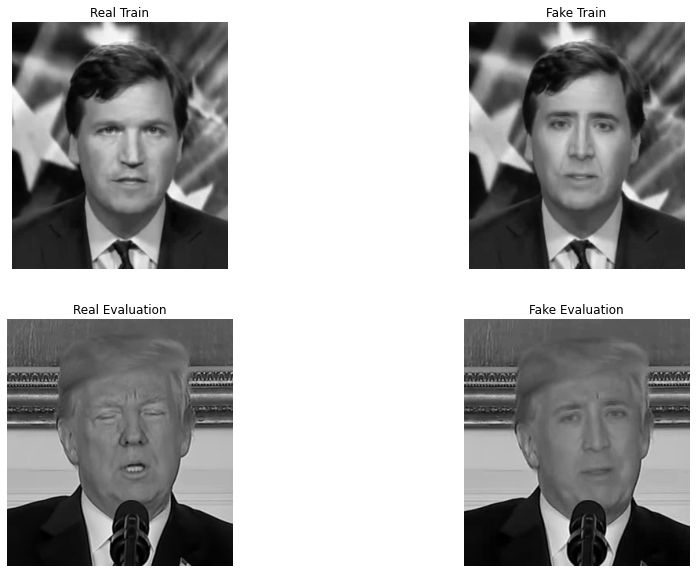

In [ ]:
# The images are not loaded in order
f, axarr = plt.subplots(2, 2, figsize=(15,10))

ima_dev_real = cv2.imread(dev_real[250], cv2.IMREAD_GRAYSCALE)
axarr[0,0].imshow(ima_dev_real, cmap = "gray")
axarr[0,0].axis('off')
axarr[0,0].set_title('Real Train')

ima_dev_fake = cv2.imread(dev_fake[250], cv2.IMREAD_GRAYSCALE)
axarr[0,1].imshow(ima_dev_fake, cmap = "gray")
axarr[0,1].axis('off')
axarr[0,1].set_title('Fake Train')

ima_eva_real = cv2.imread(eva_real[54], cv2.IMREAD_GRAYSCALE)
axarr[1,0].imshow(ima_eva_real, cmap = "gray")
axarr[1,0].axis('off')
axarr[1,0].set_title('Real Evaluation')

ima_eva_fake = cv2.imread(eva_fake[32], cv2.IMREAD_GRAYSCALE)
axarr[1,1].imshow(ima_eva_fake, cmap = "gray")
axarr[1,1].axis('off')
axarr[1,1].set_title('Fake Evaluation')

plt.show()

# Feature Extraction

### Detect face

Load face detector (external)

In [34]:
# download if missing http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
def load_facedetector():
    """Loads dlib face and landmark detector."""
    
    if not os.path.isfile("/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/Face warp artifacts experiment/dlib_model/shape_predictor_68_face_landmarks.dat"):
        print ('Could not find shape_predictor_68_face_landmarks.dat.')
        exit(-1)
    face_detector = dlib.get_frontal_face_detector()
    sp68 = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/Face warp artifacts experiment/dlib_model/shape_predictor_68_face_landmarks.dat")

    return face_detector, sp68

face_detector, sp68 = load_facedetector()

Extract landmarks

In [35]:
def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)
    for i in range(0, number_of_points):
        points[i] = (shape.part(i).x, shape.part(i).y)

    return points
    
def get_crops_landmarks(facedetector, sp68, img, roi_delta=0.0, min_score=0.0):
    """Detects faces and landmarks in image, crops image to face region."""
    face_crops = []
    final_landmarks = []

    dets, scores, idx = facedetector.run(img, 0, 0)

    num_faces = len(dets)
    if num_faces == 0:
        return face_crops, final_landmarks

    # extract especially frontal faces
    if min_score > 0.0:
        dets_new = []
        for i in range(len(dets)):
            if scores[i] > min_score:
                dets_new.append(dets[i])
        dets = dets_new

    # detect landmarks and transform to np array
    landmarks = []
    for detection in dets:
        sp_result = sp68(img, detection)
        landmarks.append(shape_to_np(sp_result))

    # crop faces
    for num in range(len(dets)):
        # copy landmarks and get crop
        face_roi = dets[num]
        face_roi = dlib.rectangle(max(0, face_roi.left()), max(0, face_roi.top()), max(0, face_roi.right()),
                                 max(0, face_roi.bottom()))

        # extend face ROI if needed
        delta_percent = roi_delta
        height = face_roi.bottom() - face_roi.top()
        delta = int(delta_percent * height)
        extended_roi_top = np.clip(face_roi.top() - delta, 0, img.shape[0])
        extended_roi_bottom = np.clip(face_roi.bottom() + delta, 0, img.shape[0])
        extended_roi_left = np.clip(face_roi.left() - delta, 0, img.shape[1])
        extended_roi_right = np.clip(face_roi.right() + delta, 0, img.shape[1])
        cropped_face = img[extended_roi_top:extended_roi_bottom, extended_roi_left:extended_roi_right, :]

        face_landmarks = landmarks[num].copy()

        face_landmarks[:, 0] = face_landmarks[:, 0] - extended_roi_left
        face_landmarks[:, 1] = face_landmarks[:, 1] - extended_roi_top

        final_landmarks.append(face_landmarks)
        face_crops.append(cropped_face)

    return face_crops, final_landmarks

### Utils for resize and extract masks

In [37]:
def new_size(org_x, org_y, large_dim=600):
    ratio = float(org_x) / float(org_y)

    if org_x > org_y:
        out_size = (int(large_dim / ratio), large_dim)
    else:
        out_size = (large_dim, int(large_dim * ratio))

    return out_size

def generate_convex_mask(shape, points_x, points_y):
    mask = np.zeros(shape, dtype=np.uint8)

    #clip to image size
    points_x = np.clip(points_x, 0, max(0, shape[1] - 1))
    points_y = np.clip(points_y, 0, max(0, shape[0] - 1))

    #set mask pixels
    mask[points_y, points_x] = 255
    mask = convex_hull_image(mask)

    return mask

### Definition of Laws filters

In [38]:
LAWS = {'L5': [1, 4, 6, 4, 1], 'E5': [-1, -2, 0, 2, 1], 'S5': [-1, 0, 2, 0, -1], 'R5': [1, -4, 6, -4, 1]}


def generate_law_filters():
    law_masks = {}
    for type1, vector1 in LAWS.items():
        for type2, vector2 in LAWS.items():
            mask_type = type1+type2
            filter_mask = np.asarray(vector1)[:, np.newaxis].T * np.asarray(vector2)[:, np.newaxis]
            law_masks[mask_type] = filter_mask

    return law_masks


def generate_mean_kernel(size):
    mean_kernel = np.ones((size, size), dtype=np.float32)
    mean_kernel = mean_kernel / mean_kernel.size

    return mean_kernel


def preprocess_image(img, size=15):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mean_kernel = generate_mean_kernel(size)
    local_means = cv2.filter2D(img, -1, mean_kernel)
    local_zero_mean_img = img - local_means

    return local_zero_mean_img


def filter_image(img, law_masks):
    law_images = {}
    for name, filter_kernel in law_masks.items():
        filtered_img = cv2.filter2D(img, -1, filter_kernel)
        law_images[name] = filtered_img

    return law_images


def compute_energy(law_images, m_size):
    laws_energy = {}
    mean_kernel = generate_mean_kernel(m_size)

    for name, law_image in law_images.items():
        law_image = np.abs(law_image)
        energy_image = cv2.filter2D(law_image, -1, mean_kernel)
        laws_energy[name] = energy_image

    laws_energy_final = {}
    laws_energy_final['L5E5_2'] = (laws_energy['L5E5'] + laws_energy['E5L5']) / 2.0
    laws_energy_final['L5R5_2'] = (laws_energy['L5R5'] + laws_energy['R5L5']) / 2.0
    laws_energy_final['E5S5_2'] = (laws_energy['S5E5'] + laws_energy['E5S5']) / 2.0
    laws_energy_final['L5S5_2'] = (laws_energy['S5L5'] + laws_energy['L5S5']) / 2.0
    laws_energy_final['E5R5_2'] = (laws_energy['E5R5'] + laws_energy['R5E5']) / 2.0
    laws_energy_final['S5R5_2'] = (laws_energy['S5R5'] + laws_energy['R5S5']) / 2.0
    laws_energy_final['S5S5'] = laws_energy['S5S5']
    laws_energy_final['R5R5'] = laws_energy['R5R5']
    laws_energy_final['E5E5'] = laws_energy['E5E5']

    return laws_energy_final

LAW_MASKS = generate_law_filters()

### Process eyes and extract features

In [39]:
LANDMARKS = {"mouth": (48, 68),
             "mouth_inner": (60, 68),
             "right_eyebrow":(17, 22),
             "left_eyebrow": (22, 27),
             "right_eye": (36, 42),
             "left_eye": (42, 48),
             "nose": (27, 35),
             "jaw": (0, 17),
             }

LEYE_LM = np.arange(LANDMARKS["left_eye"][0], LANDMARKS["left_eye"][1])
REYE_LM = np.arange(LANDMARKS["right_eye"][0], LANDMARKS["right_eye"][1])

def extract_features_mask(img, mask):
    """Computes law texture features for masked area of image."""
    preprocessed_img = preprocess_image(img, size=15)
    law_images = filter_image(preprocessed_img, LAW_MASKS)
    law_energy = compute_energy(law_images, 10)

    energy_features_list = []
    for type, energy in law_energy.items():
        # extract features for mask
        energy_masked = energy[np.where(mask != 0)]
        energy_feature = np.mean(energy_masked, dtype=np.float32)
        energy_features_list.append(energy_feature)

    return energy_features_list

def extract_features_eyes(landmarks, face_crop, scale=256):
    # generate mask for eyes
    l_eye_marks = landmarks[LEYE_LM]
    r_eye_marks = landmarks[REYE_LM]
    l_eye_mask = generate_convex_mask(face_crop[..., 0].shape, l_eye_marks[..., 0], l_eye_marks[..., 1])
    r_eye_mask = generate_convex_mask(face_crop[..., 0].shape, r_eye_marks[..., 0], r_eye_marks[..., 1])
    eye_mask = np.logical_or(l_eye_mask, r_eye_mask)
    eye_mask = eye_mask.astype(dtype=np.uint8)

    # resize input
    out_size = new_size(face_crop.shape[1], face_crop.shape[0], large_dim=scale)
    eye_mask = cv2.resize(eye_mask, (out_size[1], out_size[0]), interpolation=cv2.INTER_NEAREST)
    face_crop = cv2.resize(face_crop, (out_size[1], out_size[0]), interpolation=cv2.INTER_LINEAR)

    #segmentation fail
    if np.sum(eye_mask) < 10:
        return None

    energy_features = extract_features_mask(face_crop, eye_mask)

    return energy_features

    
def process_faces(face_crop_list, landmarks_list, scale=256):
  final_feature_vector_0 = None

  for num in range(len(face_crop_list)):
    landmarks = landmarks_list[num].copy()
    face_crop = face_crop_list[num]

    features_0 = extract_features_eyes(landmarks, face_crop, scale=scale)
      
    if features_0 is not None:
      final_feature_vector_0 = features_0 

  valid_segmentation = final_feature_vector_0 is not None

  return final_feature_vector_0, valid_segmentation

### Features extraction for the dataset

In [40]:
def getFaceLandmarks(path): 
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  extend_roi = 0.0
  face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img,
                                                    roi_delta=extend_roi)
  return face_crops, final_landmarks

In [53]:
feat_names = ['label', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9']
train_size = len(dev_real)+len(dev_fake)
test_size = len(eva_real)+len(eva_fake)

data_train = np.zeros((train_size, len(feat_names)), dtype=np.float32)
data_test = np.zeros((test_size, len(feat_names)), dtype=np.float32)

i = 0
discard_dev = 0
for path in dev_fake:
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256)

  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_dev+=1
  feature_vector.insert(0,0)
  data_train[i, :] = feature_vector
  i = i+1

for path in dev_real:  
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256) 
  
  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_dev+=1
  feature_vector.insert(0,1)
  data_train[i, :] = feature_vector
  i = i+1

j = 0
discard_eva = 0
for path in eva_fake:
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256) 

  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_eva+=1
  feature_vector.insert(0,0)
  data_test[j, :] = feature_vector
  j = j+1

for path in eva_real:
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256) 
  
  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_eva+=1
  feature_vector.insert(0,1)
  data_test[j, :] = feature_vector
  j = j+1

print(len(data_train))
print(len(data_test))
print('Discarded in development dataset', discard_dev)
print('Discarded in evaluation dataset', discard_eva)

760
210
Discarded in development dataset 2
Discarded in evaluation dataset 6


In [48]:
% cd /content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/CODE/TASK_1

/content/drive/.shortcut-targets-by-id/1hMajpu3lOFIQtcgOnINnNkd6M7Xf_-Tu/CODE/TASK_1


In [49]:
# Convert to dataframe
df_train = pd.DataFrame(data=data_train, columns=feat_names)
df_test = pd.DataFrame(data=data_test, columns=feat_names)

Save features as CSV

In [56]:
df_train.to_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/CODE/TASK_1/train_data.csv"), index=False)
df_test.to_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/CODE/TASK_1/test_data.csv"), index=False)

# Load from CSV

For testing different models, in the cases when the face is not detected, we must replace the empty values. The most effective approach was to replace by the mean of the dataset. 

In [ ]:
input_test = pd.read_csv(os.path.join(root_dir, 'test_data.csv'))
input_train = pd.read_csv(os.path.join(root_dir, 'train_data.csv'))

# Fill zeros with mean
input_train = input_train.fillna(input_train.mean()) 
input_test = input_test.fillna(input_test.mean()) 

# Compute correlation matrix

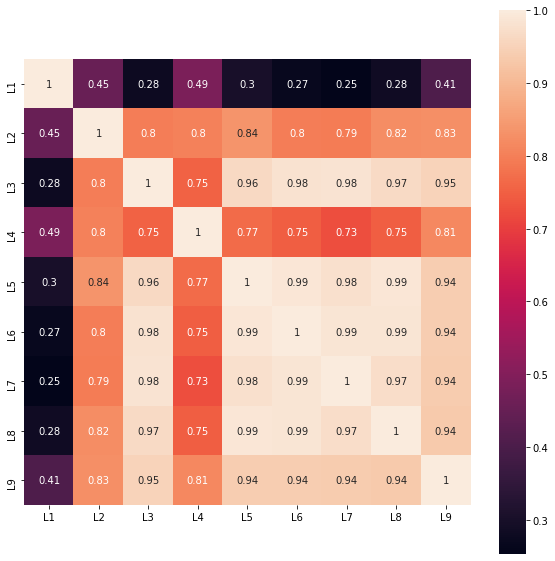

In [ ]:
x_data = input_train.iloc[:, 1:]

c_mat = x_data.corr()
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(c_mat,vmax=1, square=True, annot=True)


L3, L5, L6 and L8 are candidates to be dropped due to their high correlations. After performing manual tests, the best results were achieved droping L3 and L5.

In [ ]:
x_train = input_train.iloc[:, [1,2,4,6,7,8,9]]
y_train = input_train.iloc[:, 0]

x_test = input_test.iloc[:, [1,2,4,6,7,8,9]]
y_test = input_test.iloc[:, 0]

# Models

### SVM

In [ ]:
modelo = SVC(C = 2, kernel = 'rbf', random_state=123,probability=True)
modelo.fit(x_train, y_train)

Compute metrics in train

Accuracy:  0.881578947368421
AUC:  0.881578947368421


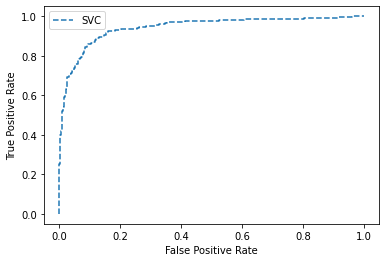

In [ ]:
y_pred_train = modelo.predict(x_train)
print('Accuracy: ', accuracy_score(y_train, y_pred_train))
print("AUC: ", roc_auc_score(y_train, y_pred_train))

svc_probs_train = modelo.predict_proba(x_train)
svc_probs_train = svc_probs_train[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, svc_probs_train)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='SVC')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Compute metrics in test

Accuracy:  0.780952380952381
AUC:  0.7804545454545455


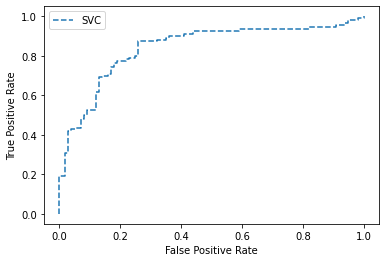

In [ ]:
y_pred_test = modelo.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred_test))
print("AUC: ", roc_auc_score(y_test, y_pred_test))

svc_probs_test = modelo.predict_proba(x_test)
svc_probs_test = svc_probs_test[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, svc_probs_test)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='SVC')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()